In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class NavierStokesDataset(Dataset):
    def __init__(self, data_dirs, future_steps=1, min_max_path=None):
        """
        Initializes the NavierStokesDataset.

        Args:
            data_dirs (list of str): List of directories containing `.npy` files.
            future_steps (int): Number of timesteps in the future the model will predict.
            min_max_path (str, optional): Path to the JSON file containing min and max values for each channel.
                                         If None, it will look for 'min_max.json' in the first data directory.
        """
        self.data_dirs = data_dirs
        self.future_steps = future_steps
        self.files = []

        # Aggregate all .npy files from the specified directories
        for data_dir in data_dirs:
            if not os.path.isdir(data_dir):
                raise ValueError(f"Data directory '{data_dir}' does not exist or is not a directory.")
            dir_files = sorted([
                os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')
            ])
            if not dir_files:
                print(f"Warning: No .npy files found in directory '{data_dir}'.")
            self.files.extend(dir_files)

        if not self.files:
            raise ValueError("No .npy files found in any of the specified directories.")

        # Load min and max values
        if min_max_path is None:
            # Assume min_max.json is in the first data directory
            min_max_path = os.path.join(data_dirs[0], 'min_max.json')
        if not os.path.exists(min_max_path):
            raise FileNotFoundError(
                f"Min and max values file not found at '{min_max_path}'. "
                "Please ensure the file exists."
            )

        with open(min_max_path, 'r') as f:
            min_max = json.load(f)
        self.channel_min = min_max['channel_min']
        self.channel_max = min_max['channel_max']

        # Validate the min and max lists
        if len(self.channel_min) != len(self.channel_max):
            raise ValueError("channel_min and channel_max must have the same length.")
        self.num_channels = len(self.channel_min)

        # Precompute the number of samples across all files
        self.samples = []
        print("Preparing dataset samples...")
        for file_idx, file in enumerate(self.files):
            try:
                data_memmap = np.load(file, mmap_mode='r')
                timesteps = data_memmap.shape[0]  # Assuming shape: (timesteps, channels, height, width)
                del data_memmap  # Close the memmap
            except Exception as e:
                print(f"Error loading file '{file}': {e}. Skipping this file.")
                continue

            max_start_t = timesteps - self.future_steps - 1
            if max_start_t < 0:
                print(f"File '{file}' has insufficient timesteps ({timesteps}) for future_steps={self.future_steps}. Skipping.")
                continue  # Skip files that don't have enough timesteps

            for start_t in range(0, max_start_t + 1):
                self.samples.append((file_idx, start_t))

        print(f"Total samples in dataset: {len(self.samples)}")

        # Precompute t1 assuming all files have the same number of timesteps
        if len(self.files) > 0:
            try:
                sample_memmap = np.load(self.files[0], mmap_mode='r')
                timesteps = sample_memmap.shape[0]
                del sample_memmap
                whole_t = timesteps + 1  # As per original code
                self.t1 = torch.tensor(
                    [(i + 1) / whole_t for i in range(self.future_steps)],
                    dtype=torch.float32
                )  # Shape: (future_steps,)
                self.t0 = torch.tensor(0.0, dtype=torch.float32)  # Scalar
            except Exception as e:
                raise ValueError(f"Error accessing timesteps from the first file: {e}")
        else:
            raise ValueError("No valid .npy files found in the specified directories.")

        # Initialize a cache for memory-mapped files to improve performance
        self._memmap_cache = {}

    def __len__(self):
        return len(self.samples)

    def normalize_channel(self, tensor, channel_idx):
        """
        Normalizes a specific channel of the tensor between 0 and 1.

        Args:
            tensor (torch.Tensor): The tensor to normalize.
            channel_idx (int): The index of the channel to normalize.

        Returns:
            torch.Tensor: The normalized tensor.
        """
        min_val = self.channel_min[channel_idx]
        max_val = self.channel_max[channel_idx]
        if max_val - min_val == 0:
            raise ValueError(
                f"Max and min values for channel {channel_idx} are the same. Cannot normalize."
            )
        tensor[:, channel_idx, :, :] = (tensor[:, channel_idx, :, :] - min_val) / (max_val - min_val)
        return tensor

    def __getitem__(self, idx):
        # Retrieve the (file_idx, start_t) tuple for this sample
        file_idx, start_t = self.samples[idx]
        file = self.files[file_idx]

        # Check if the memmap for this file is already cached
        if file not in self._memmap_cache:
            try:
                # Memory-map the file and store in cache
                data_memmap = np.load(file, mmap_mode='r')
                self._memmap_cache[file] = data_memmap
            except Exception as e:
                raise ValueError(f"Error loading file '{file}': {e}")

        data_memmap = self._memmap_cache[file]

        # Convert to PyTorch tensor
        try:
            # Access the required timesteps: start_t to start_t + 1 + future_steps
            required_timesteps = slice(start_t, start_t + 1 + self.future_steps)
            data = data_memmap[required_timesteps, :, :, :]  # Shape: (future_steps +1, channels, height, width)
        except Exception as e:
            raise ValueError(f"Error accessing timesteps {start_t} to {start_t + self.future_steps +1} in file '{file}': {e}")

        # **Make a writable copy of the data**
        data_copy = data.copy()

        # Convert to PyTorch tensor
        data_tensor = torch.from_numpy(data_copy).float()  # Shape: (future_steps +1, channels, height, width)

        # Normalize each channel between 0 and 1 using precomputed min and max
        for channel_idx in range(self.num_channels):
            data_tensor = self.normalize_channel(data_tensor, channel_idx)

        # Extract input timestep
        ic = data_tensor[0]  # Shape: (channels, height, width)

        # Prepare the target sequence (ground truth)
        target = data_tensor[1:]  # Shape: (future_steps, channels, height, width)

        return ic, self.t0, self.t1, target

    def __del__(self):
        # Close all memmap files when the dataset is deleted
        for memmap in self._memmap_cache.values():
            del memmap
        self._memmap_cache.clear()

def custom_collate_fn(batch):
    """
    Custom collate function to rearrange the target tensor.

    Args:
        batch: A list of tuples (ic, t0, t1, target)

    Returns:
        Batched tensors and fixed time indicators:
            - ic: (batch_size, channels, height, width)
            - t0: 0.0 (scalar tensor)
            - t1: (future_steps,) tensor
            - target: (future_steps, batch_size, channels, height, width)
    """
    ic, t0, t1, target = zip(*batch)

    # Stack the initial conditions into a tensor
    ic = torch.stack(ic, dim=0)  # Shape: (batch_size, channels, height, width)

    # Since t0 is always 0.0, return a single scalar tensor
    t0 = torch.tensor(0.0, dtype=torch.float32)  # Scalar tensor

    # Since t1 is consistent across all samples, take the first one
    t1 = t1[0]  # Shape: (future_steps,)

    # Stack targets into a tensor and permute to match desired shape
    target = torch.stack(target, dim=0).permute(1, 0, 2, 3, 4)  # Shape: (future_steps, batch_size, channels, height, width)

    return ic, t0, t1, target

# Example usage:
if __name__ == "__main__":
    # Paths to your train and test directories
    data_dirs_train = ['/project/vil_baek/data/physics/PARCTorch/NavierStokes/train' ]  # Replace with your actual train directory path
    data_dirs_test = ['/project/vil_baek/data/physics/PARCTorch/NavierStokes/test']    # Replace with your actual test directory path

    # Define the number of future steps you want
    future_steps = 1  # Example: Predicting 1 future timestep

    # Path to the min_max.json file
    min_max_path = os.path.join('..', 'Data', 'ns_min_max.json')

    # Initialize the dataset with both train and test directories
    navier_stokes_dataset = NavierStokesDataset(
        data_dirs=data_dirs_train + data_dirs_test,
        future_steps=future_steps,
        min_max_path=min_max_path
    )

    # Create a DataLoader for batching with the custom collate function
    batch_size = 8  # Specify your desired batch size
    data_loader = DataLoader(
        navier_stokes_dataset,
        batch_size=batch_size,
        shuffle=False,                   # Set to True if you want to shuffle the data
        num_workers=4,                   # Adjust based on your CPU cores
        pin_memory=True,                 # If using a GPU
        collate_fn=custom_collate_fn     # Use the custom collate function
    )

    # Example to inspect t0 and t1
    for batch in data_loader:
        ic, t0, t1, target = batch
        print("ic shape:", ic.shape)          # (batch_size, channels, height, width)
        print("t0:", t0)                      # 0.0
        print("t1 shape:", t1.shape)          # (future_steps,)
        print("target shape:", target.shape)  # (future_steps, batch_size, channels, height, width)
        break  # Remove this to iterate through the entire dataset


Preparing dataset samples...
Total samples in dataset: 1368
ic shape: torch.Size([8, 4, 128, 256])
t0: tensor(0.)
t1 shape: torch.Size([1])
target shape: torch.Size([1, 8, 4, 128, 256])


In [3]:
# Example usage of DataLoader with the PARCv2 model
for ic, t0, t1, data_tensor in data_loader:
    # Print the shape of the tensors
    print(f"Initial condition (ic) shape: {ic.shape}")
    print(f"t0 shape: {t0.shape}")
    print(f"t1 shape: {t1.shape}")
    print(f"Full data sequence shape: {data_tensor.shape}")
    
    # Break after one batch to avoid printing too much
    break


Initial condition (ic) shape: torch.Size([8, 4, 128, 256])
t0 shape: torch.Size([])
t1 shape: torch.Size([1])
Full data sequence shape: torch.Size([1, 8, 4, 128, 256])


In [3]:
# ask xinlun if he wants me to squeeze the batch
print(t1)
print(1/40, 2/40, 3/40)

tensor([0.0250])
0.025 0.05 0.075


In [13]:
print(ic[:, 3, :, :])

tensor([[[0.5085, 0.5085, 0.5085,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5085,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5084,  ..., 0.5085, 0.5085, 0.5085],
         ...,
         [0.5085, 0.5086, 0.5086,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5086,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5085,  ..., 0.5085, 0.5085, 0.5085]],

        [[0.5085, 0.5085, 0.5085,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5084,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5084, 0.5084,  ..., 0.5085, 0.5085, 0.5085],
         ...,
         [0.5085, 0.5086, 0.5086,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5086,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5085,  ..., 0.5085, 0.5085, 0.5085]],

        [[0.5085, 0.5085, 0.5085,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5085, 0.5084,  ..., 0.5085, 0.5085, 0.5085],
         [0.5085, 0.5084, 0.5084,  ..., 0.5085, 0.5085, 0.

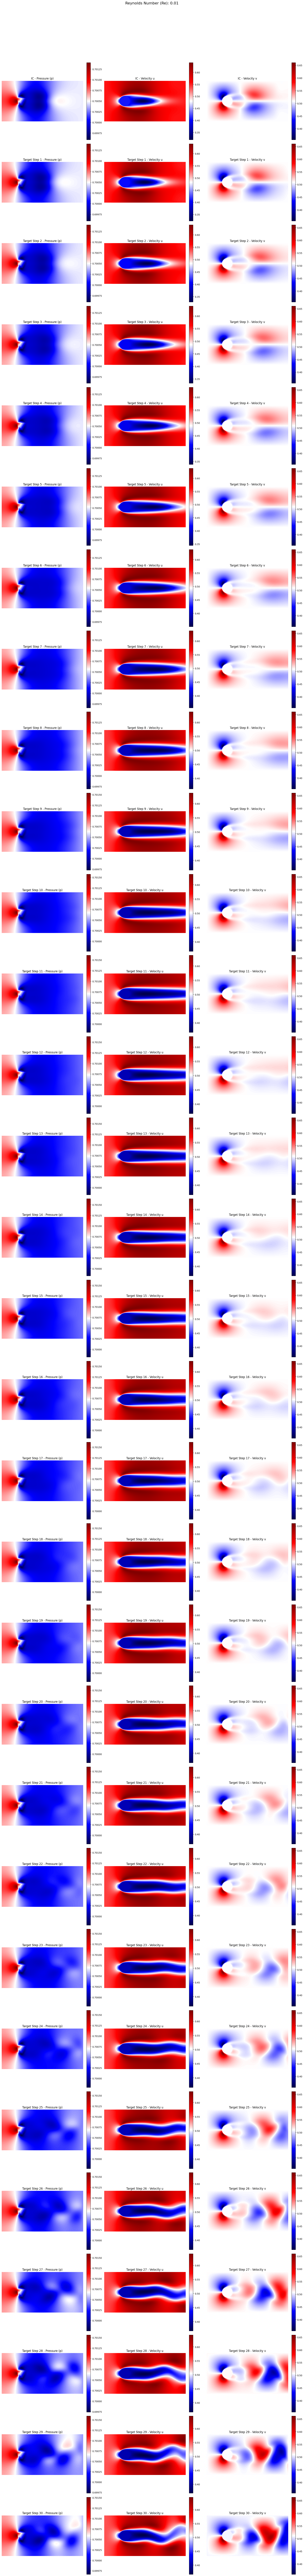

In [7]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming the NavierStokesDataset and DataLoader have been defined as per previous steps

def visualize_sample(data_loader, dataset, sample_index=0):
    """
    Visualizes the input condition and ground truth sequence for a given sample in the DataLoader.
    
    Args:
        data_loader (DataLoader): The DataLoader instance.
        dataset (NavierStokesDataset): The dataset instance.
        sample_index (int): Index of the sample within the batch to visualize (default is 0).
    """
    # Get one batch from the DataLoader
    batch = next(iter(data_loader))
    ic_batch, t0, t1, target_batch = batch

    # Select the sample_index from the batch
    ic = ic_batch[sample_index]             # Shape: (4, height, width)
    target = target_batch[:, sample_index]   # Shape: (future_steps, 4, height, width)

    # Extract channels
    # Channels: 0 - u, 1 - Re, 2 - v, 3 - p
    p_ic = ic[0].numpy()
    Re_ic = ic[1].numpy()
    u_ic = ic[2].numpy()
    v_ic = ic[3].numpy()
    
    

    # Prepare for visualization
    future_steps = target.shape[0]

    # Create subplots
    # We'll create a figure with (future_steps + 1) rows and 3 columns:
    # 1 row for the input condition and 'future_steps' rows for the targets
    fig, axes = plt.subplots(future_steps + 1, 3, figsize=(18, 5 * (future_steps + 1)))

    # Titles for the channels
    channel_titles = ['Pressure (p)', 'Velocity u', 'Velocity v']

    # Visualization for Input Condition (ic)
    # Pressure
    im0_p = axes[0, 0].imshow(p_ic, cmap='seismic')
    axes[0, 0].set_title(f'IC - {channel_titles[0]}')
    axes[0, 0].axis('off')
    plt.colorbar(im0_p, ax=axes[0, 0], fraction=0.046, pad=0.04)

    # Velocity u
    im0_u = axes[0, 1].imshow(u_ic, cmap='seismic')
    axes[0, 1].set_title(f'IC - {channel_titles[1]}')
    axes[0, 1].axis('off')
    plt.colorbar(im0_u, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # Velocity v
    im0_v = axes[0, 2].imshow(v_ic, cmap='seismic')
    axes[0, 2].set_title(f'IC - {channel_titles[2]}')
    axes[0, 2].axis('off')
    plt.colorbar(im0_v, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Extract a scalar value for Reynolds Number
    # Since Re_ic is a 2D array with constant values, we can take the first element
    Re_scalar = Re_ic[0, 0]
    Re_text = f'Reynolds Number (Re): {Re_scalar:.2f}'
    
    # Add Reynolds Number as a central title above all subplots
    fig.suptitle(Re_text, fontsize=16, y=0.98, ha='center')

    # Visualization for Each Target Timestep
    for step in range(future_steps):
        # Extract target channels
        target_p = target[step, 0].numpy()
        target_Re = target[step, 1].numpy()
        target_u = target[step, 2].numpy()
        target_v = target[step, 3].numpy()
        

        # Pressure
        im_p = axes[step + 1, 0].imshow(target_p, cmap='seismic')
        axes[step + 1, 0].set_title(f'Target Step {step + 1} - {channel_titles[0]}')
        axes[step + 1, 0].axis('off')
        plt.colorbar(im_p, ax=axes[step + 1, 0], fraction=0.046, pad=0.04)

        # Velocity u
        im_u = axes[step + 1, 1].imshow(target_u, cmap='seismic')
        axes[step + 1, 1].set_title(f'Target Step {step + 1} - {channel_titles[1]}')
        axes[step + 1, 1].axis('off')
        plt.colorbar(im_u, ax=axes[step + 1, 1], fraction=0.046, pad=0.04)

        # Velocity v
        im_v = axes[step + 1, 2].imshow(target_v, cmap='seismic')
        axes[step + 1, 2].set_title(f'Target Step {step + 1} - {channel_titles[2]}')
        axes[step + 1, 2].axis('off')
        plt.colorbar(im_v, ax=axes[step + 1, 2], fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
    plt.show()


# Example usage:
# Assuming you have defined 'data_loader' and 'navier_stokes_dataset' as per previous code
visualize_sample(data_loader, navier_stokes_dataset, sample_index=5)
